## Import libraries

In [25]:

import pyrealsense2 as rs
import numpy as np
import cv2
from matplotlib import pyplot as plt
import re
import os
import time
import math



### constants to sync with values in d435-capture.ipynb



In [26]:
depth_scale = 9.999999747378752e-05
imgfolder = "D:/d435/test/"
width = 1280
height = 720


### fetch all file names


In [27]:
filelist = sorted(os.listdir(imgfolder))

# ['c_1540534762479.1584.npy', 'c_1540534762645.808.npy', 'c_1540534762813.2444.npy', 
#  'd_1540534762479.1584.npy', 'd_1540534762645.808.npy', 'd_1540534762813.2444.npy']
print(filelist)

timesteps = []
filetimes = []
color_files = []
depth_files = []
base_time = -1.0

for f in filelist:
    result = re.search('c_(.*).npy', f)
    if result and result.group(1):
        t = result.group(1)
        timesteps.append(float(t))
        if base_time < 0:
            base_time = float(t)
        filetimes.append(t)
        color_files.append(f)
        depth_files.append("d_" + t + ".npy")

print(timesteps)
print(depth_files)
print(len(depth_files))

['c_1540534762479.1584.npy', 'c_1540534762645.808.npy', 'c_1540534762813.2444.npy', 'd_1540534762479.1584.npy', 'd_1540534762645.808.npy', 'd_1540534762813.2444.npy']
[1540534762479.1584, 1540534762645.808, 1540534762813.2444]
['d_1540534762479.1584.npy', 'd_1540534762645.808.npy', 'd_1540534762813.2444.npy']
3


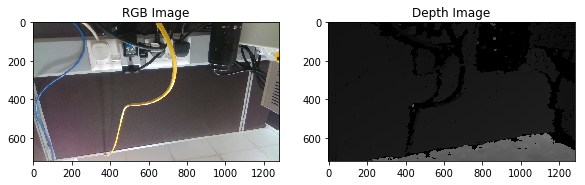

In [28]:
color_image = np.load(imgfolder + color_files[1])
depth_image = np.load(imgfolder + depth_files[1])


# Show images
fig = plt.figure(figsize=(15, 15))
table1 = fig.add_subplot(1,3,1)
table1.set_title("RGB Image")
table1.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

table2 = fig.add_subplot(1,3,2)
table2.set_title("Depth Image")
table2.imshow(depth_image, cmap='gray')


In [29]:
print(depth_image.shape)
print(depth_image[450,180])
print(depth_image[450,180]*depth_scale)

print(color_image.shape)
print(color_image[450,180])

max_depth = int(0.5/depth_scale)
print("Max Depth Int ",max_depth)

min_depth = int(0.2/depth_scale)
print("Min Depth Int ",min_depth)

(720, 1280)
5723
0.572299985542
(720, 1280, 3)
[71 63 81]
Max Depth Int  5000
Min Depth Int  2000


In [43]:
radian_size = 6283
h_fov = 69.4*math.pi/180
# the tangent constant for the FOV/2 of the camera
fov_tan = math.tan(h_fov/2)
# distance between turntable center and camera
turn_dist = 0.5

# 33.33 rpm = 3.49065846509342 rad/s
rotate_speed = 3.49065846509342

cylinder_depth = np.zeros((720,radian_size), dtype=float)
cylinder_count = np.zeros((720,radian_size), dtype=int)
cylinder_r = np.zeros((720,radian_size), dtype=float)
cylinder_g = np.zeros((720,radian_size), dtype=float)
cylinder_b = np.zeros((720,radian_size), dtype=float)


#    x′ = x cos ⁡ θ − y sin ⁡ θ
#    y′ = x sin ⁡ θ + y cos ⁡ θ

for n in range(len(depth_files)):
    print("Processing ",color_files[n])
    color_image = np.load(imgfolder + color_files[n])
    depth_image = np.load(imgfolder + depth_files[n])
    # timedelta is in seconds
    time_delta = (timesteps[n] - base_time)/1000
    angle_delta = (time_delta * rotate_speed) % (2*math.pi)
    for x in range(width):
        for z in range(height):
            y = depth_image[z,x]
            r = color_image[z,x,2]
            g = color_image[z,x,1]
            b = color_image[z,x,0]
            # cam_y is in metres
            cam_y = y * depth_scale
            if cam_y > turn_dist:
                continue
            # x in camera coord
            cam_x = ((x - (width/2))/(width/2)) * cam_y *  fov_tan
            # convert to center of turntable coordinates
            turn_x = cam_x
            turn_y = cam_y - turn_dist
            # rotate by angle_delta
            rot_x = turn_x * math.cos(angle_delta) - turn_y * math.sin(angle_delta)
            rot_y = turn_x * math.sin(angle_delta) + turn_y * math.cos(angle_delta)            
            # rot_radius = depth is now distance from the turntable center
            # rot_angle is between -pi and pi
            rot_radius = math.sqrt(rot_x*rot_x + rot_y*rot_y)
            rot_angle = math.atan2(rot_y, rot_x)
            rot_coord = int(radian_size * (rot_angle + math.pi)/(2*math.pi))
            # record into the arrays
            if cylinder_count[z, rot_coord] > 0:
                count = cylinder_count[z, rot_coord]
                cylinder_depth[z, rot_coord] = ((cylinder_depth[z, rot_coord] * count) + rot_radius) / (count + 1)
                cylinder_r[z, rot_coord] = ((cylinder_r[z, rot_coord] * count) + r) / (count + 1)
                cylinder_g[z, rot_coord] = ((cylinder_g[z, rot_coord] * count) + g) / (count + 1)
                cylinder_b[z, rot_coord] = ((cylinder_b[z, rot_coord] * count) + b) / (count + 1)
            else:
                cylinder_depth[z, rot_coord] = rot_radius
                cylinder_r[z, rot_coord] = r
                cylinder_g[z, rot_coord] = g
                cylinder_b[z, rot_coord] = b
            cylinder_count[z, rot_coord] += 1
            
print("Done")

Processing  c_1540534762479.1584.npy
Processing  c_1540534762645.808.npy
Processing  c_1540534762813.2444.npy
Done


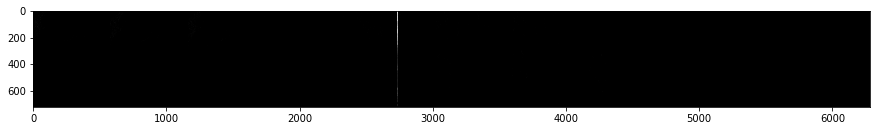

In [44]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(cylinder_count, cmap='gray')
plt.show()


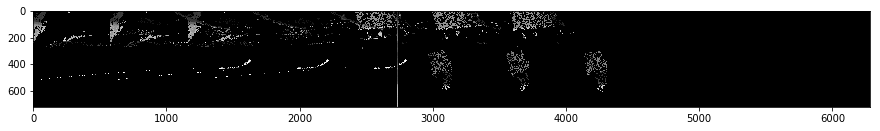

In [46]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(cylinder_r, cmap='gray')
plt.show()


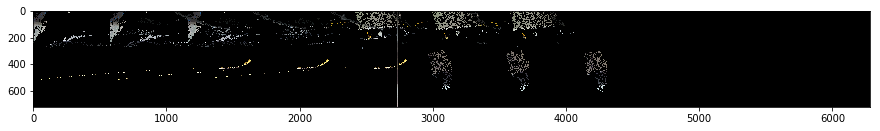

In [47]:
rgbArray = np.zeros((720,radian_size,3), 'uint8')
rgbArray[..., 0] = cylinder_r
rgbArray[..., 1] = cylinder_g
rgbArray[..., 2] = cylinder_b

fig = plt.figure(figsize=(15, 15))
plt.imshow(rgbArray)
plt.show()
